# Introduction to NLP Fundamentals in TensorFlow

NLP has the goal of deriving information out of natural language (could be sequences, text or speech)

Another common term for NLP problems is sequence to sequence problems (seq2seq).


In [ ]:
## Check for GPU

In [ ]:
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


## Get helper functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2023-10-17 19:19:45--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-10-17 19:19:45 (77.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get a text dataset

The dataset we're going to be using is Kaggle's introduction to NLP dataset (text samples of Twees labelled as disaster or not disaster).

See the original source here: https://www.kaggle.com/competitions/nlp-getting-started

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

--2023-10-17 19:19:52--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.217.207, 173.194.218.207, 108.177.11.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.217.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.005s  

2023-10-17 19:19:52 (127 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [ ]:
# Unzip data
unzip_data("nlp_getting_started.zip")

## Visualizing a text dataset

TO visualize our text samples, we first have to read them in, one way to do so would be to use python: https://realpython.com/read-write-files-python/

But i prefer to get visual straight away.

So another way to do this is to update pandas..

In [ ]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
# What does the test dataframe look like?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

is the data is in imbalance: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [ ]:
# How manu total samples
len(train_df), len(test_df)

(7613, 3263)

In [ ]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df) -5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0 (not real disaster)
Text:
http://t.co/iNkuv5DNTX #auction #shoes Retro 5 fire red http://t.co/1cvEGTIZOG

---

Target: 1 (real disaster)
Text:
Islamic State claims suicide bombing at Saudi Arabian mosque: Ten members of emergency service... http://t.co/mpOaEFQl6k via @josephjett

---

Target: 1 (real disaster)
Text:
The sign-up is open for the FALLING FOR DANGER release day blast and review tour. Sign-up here:... http://t.co/hbdo22nqPZ

---

Target: 1 (real disaster)
Text:
@TheBlackshag @dannyoneil too toxic...cancer....disease...hazardous waste...noxious...

---

Target: 0 (not real disaster)
Text:
@michelleellle ?? shut up freshman its past ur curfew. u need some sleep!! u spend too much of ur time watching tv instead of going outside ??

---



### Splot data into training and validation sets


In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1,  # use 10% of training data for validation split
                                                                            random_state=42)


In [ ]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [ ]:
len(train_df_shuffled)

7613

In [ ]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Converting text into numbers

When dealing with a text problem, one of the first things you'll have to do before you can build a model is to convert your text to numbers.

There are few ways to do this, namely:
* Tokenziation - direct mapping of token (a token could be a word or a character) to number
* Embedding - create a matrix of feature vector for each token (the size of the feature vector can be defined and this embedding can be learned)

In [ ]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [ ]:
### Text vectorization (tokenization)
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=16000, # how many words in the vocabulary (automatically add <OOV>)
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # hwo to map tokens to numbers
                                    output_sequence_length=None, # how long do you want your sequences to be?
                                    pad_to_max_tokens=True)

In [ ]:
len(train_sentences[0].split())

7

In [ ]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [ ]:
# Setup text vectorization variables
max_vocab_length = 10000    # max number of words to have in our vocabulary
max_length = 15   # max length our sequences will be (e.g. how many words from a Tweet does a model see?)

text_vectorizer = TextVectorization(max_tokens = max_vocab_length,
                                    output_mode = "int",
                                    output_sequence_length = max_length)

In [ ]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [ ]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [ ]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
 -=-0!!!!. Photo: LASTMA officials challenge police for driving against traffic in Lagos http://t.co/8VzsfTR1bG      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[1340,  343,    1,  503, 3117,   77,   10, 1027,  445,  592,    4,
           1,    1,    0,    0]])>

In [ ]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()   # get all of the unique words in our training data
top_5_words = words_in_vocab[:5]  # get the most common words
bottom_5_words = words_in_vocab[-5:]   # ge the least common words
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 most common words: {top_5_words}")
print(f"5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using an Embedding Layer

To make our embedding, we're going to use TensorFlows layer: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

The parameters we care most about for our embedding layer:
* `input_dim` = the size of our vocabulary
* `output_dim` = the size of the output embedding vector, for example, a value of 100 would mean each token gets represented by a vector 100 long
* `input_length` = length of the sequences being passed to the embedding layer

In [ ]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length,    # set input shape
                             output_dim=128,          # output shape
                             embeddings_initializer="uniform",
                             input_length=max_length    # how long is each input
                             )
embedding

In [ ]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
        \n\nEmbedded version:")

# Embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
 Russian 'food crematoria' provoke outrage amid crisis famine memories http://t.co/h6Z7hXUqtu via @YahooNews        

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.04938252,  0.03198797,  0.00913043, ...,  0.00777214,
         -0.02909811,  0.03389418],
        [-0.03672735, -0.00050954,  0.02144038, ...,  0.01197642,
         -0.00505542,  0.04491753],
        [ 0.02091029, -0.01290735,  0.01961854, ..., -0.00542327,
          0.01750309, -0.00962093],
        ...,
        [-0.02747806, -0.035623  ,  0.04623203, ...,  0.03050648,
          0.00400158,  0.02692882],
        [-0.02747806, -0.035623  ,  0.04623203, ...,  0.03050648,
          0.00400158,  0.02692882],
        [-0.02747806, -0.035623  ,  0.04623203, ...,  0.03050648,
          0.00400158,  0.02692882]]], dtype=float32)>

In [ ]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence[0], random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 4.93825190e-02,  3.19879688e-02,  9.13042948e-03, -2.87889242e-02,
         2.07538493e-02, -1.98537949e-02,  3.69608402e-04, -3.11943293e-02,
         1.21174082e-02, -4.63729762e-02, -1.63932815e-02, -5.07290289e-03,
        -1.87812336e-02,  3.83575670e-02,  1.96924917e-02, -3.42182294e-02,
         4.58070524e-02,  1.91159584e-02,  2.56392621e-02,  4.08700742e-02,
         1.23516694e-02, -9.43287462e-03, -4.08363342e-03, -4.45100665e-02,
        -9.39805433e-03,  2.45734118e-02,  1.11891404e-02, -2.41193529e-02,
         2.63675489e-02,  4.13616411e-02,  4.02054824e-02,  3.08212899e-02,
         3.08916718e-03,  4.55222838e-02,  4.08040360e-03, -4.08582687e-02,
        -8.52749497e-03, -4.01812419e-02,  2.42853165e-03, -2.64521688e-03,
         4.87921275e-02, -3.21892984e-02,  2.87407525e-02, -4.80036736e-02,
         2.74609439e-02, -3.42092067e-02,  2.09623910e-02, -3.60107422e-02,
         9.74883884e-03,  1.82410218e-0

## Modelling a text dataset (running a series of experiments)

Now we've a got way to turn our text sequences into numbers, it's time to start building a series of modelling experiments.

We'll start with a baseline and move on from there.

* Model 0: Naive Bayes (baseline), this is from Sklearn ML map: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidirectional-LSTM model (RNN)
* Model 5: 1D COnvolutional Neural Network (CNN)
* Model 6: TensorFlow HUb Pretrained Feature Extractor (using transfer learning for NLP)
* Model 7: Some as model 6 with 10% of training data

How are we going approach all these?

Use the standard steps in the modelling with tensorflow:


### Model 0: Getting a baseline
As with all machine learning modelling experiments, it's important to create a baseline model so you've got a benchmark for future experiments to build upon.

To create our baseline we'll use Sklearn's Multinomial Navie Bayes using the TF-IDF formula to conver our words to numbers.

> 🔑 **Note:** It's coomon pracice to use non-DL algorithms as baseline because of their speed and then later using DL to see if you can imrpove upon them.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),   # convert words to numbers using tfidf
    ("clf", MultinomialNB())  # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [ ]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an evaluation function for our model experiments

We could evaluate all of our model's predictions with differents metrics every tiime, however, this will be cumbersome and could easily be fixed with a function..
Let's create one to compare our model's predictions with the truth labels using the following metrics:
* Accuracy
* precision
* Recall
* F1-score

> For a deep overview of many different evaluation methods, see the Sklearn documentation: https://scikit-learn.org/stable/modules/model_evaluation.html

In [ ]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1-score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1": model_f1}
  return model_results

In [ ]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 1: A simple dense model

In [ ]:
# Create a tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create a directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [ ]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)  # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x)  # create an embedding of the numberized inputs
x = layers.GlobalAveragePooling1D()(x) # condense the feature vector for each token to one vector
# x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)  # Create the output layer, want binary outputs so use sigmoid activation function
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [ ]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [ ]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20231017-191954
Epoch 1/5
215/215 [==============================] - 11s 45ms/step - loss: 0.6097 - accuracy: 0.6906 - val_loss: 0.5336 - val_accuracy: 0.7612
Epoch 2/5
215/215 [==============================] - 9s 42ms/step - loss: 0.4399 - accuracy: 0.8196 - val_loss: 0.4709 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 8s 36ms/step - loss: 0.3465 - accuracy: 0.8608 - val_loss: 0.4591 - val_accuracy: 0.7913
Epoch 4/5
215/215 [==============================] - 6s 29ms/step - loss: 0.2830 - accuracy: 0.8913 - val_loss: 0.4667 - val_accuracy: 0.7848
Epoch 5/5
215/215 [==============================] - 5s 24ms/step - loss: 0.2365 - accuracy: 0.9120 - val_loss: 0.4812 - val_accuracy: 0.7887


In [ ]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 2ms/step - loss: 0.4812 - accuracy: 0.7887


[0.4812013804912567, 0.7887139320373535]

In [ ]:
# Make some predictions and evaluate those
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

24/24 [==============================] - 0s 3ms/step


(762, 1)

In [ ]:
# look at a single prediction
model_1_pred_probs[0]

array([0.35576156], dtype=float32)

In [ ]:
# look at the first 10 predictions
model_1_pred_probs[:10]

array([[0.35576156],
       [0.7697748 ],
       [0.9977246 ],
       [0.07606471],
       [0.10275953],
       [0.94554436],
       [0.9348573 ],
       [0.9939737 ],
       [0.96452945],
       [0.20371307]], dtype=float32)

In [ ]:
# Convert model prediction probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)>

In [ ]:
# Calculate our model_1 results
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.87139107611549,
 'precision': 0.7948464726843409,
 'recall': 0.7887139107611548,
 'f1': 0.7853694687698636}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [ ]:
# Looks like our baseline is out performing our first deep learning model..
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

## Visuzlizing learned embeddings

In [ ]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [ ]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [ ]:
# Get the weight matrix of embedding layer
# (these are the numerical representations of each token in our training data, which have been learned for -5 epochs)
embed_weights = model_1.get_layer("embedding").get_weights()[0]
print(embed_weights.shape)  # same size as vocab size and embedding_dim (output_dim of our embedding layer)

(10000, 128)


Now we've got the embedding matrix our model has learned to represent our tokens, let's see how we can visualize it.

To do so, TensorFLow has a handy tool called projector: http://projector.tensorflow.org/

And TensorFlow also has an incredible guide on word embeddings themselves: https://www.tensorflow.org/text/guide/word_embeddings

Read through https://jalammar.github.io/illustrated-word2vec/

In [ ]:
# Create embedding files (we got this from TensorFlow's word embeddings documentation)
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [ ]:
# Download files from Colab to upload to projector
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Recurrent Neural Networks (RNN's)
RNN's are usuful for sequence data.

The premise of a recurrent neural network is to use the representation of a previous input to aid the representation of a later input.

**Resources:**If you want an overview of the internals of a recurrent neural network, see the following:
- MIT's sequence modelling lecture https://www.youtube.com/watch?v=SEnXr6v2ifU
- Chris Olah's intro to LSTMs: https://colah.github.io/posts/2015-08-Understanding-LSTMs/
- Adrej Karpathy's the unreasonable effectiveness of recurrent neural networks: https://karpathy.github.io/2015/05/21/rnn-effectiveness/

### Model 2: LSTM

LSTM = long short term memory (one of the most popular LSTM cells)

Our structure of an RNN typically looks like this:

```
Input (text) -> Tokenize -> Embedding -> Layers (RNNs/dense) -> Output (label probability)
```

Read: tanh : https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html

In [ ]:
# Create an LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
#print(x.shape)
#x = layers.LSTM(units=64, return_sequences=True)(x) # when you're stacking RNN cells together, you need to set return_sequences=True
#print(x.shape)
x = layers.LSTM(64)(x)
#print(x.shape)
#x = layers.Dense(64, activation="relu")(x)
#print(x.shape)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

In [ ]:
# Get a summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1329473 (5.07 MB)
Trainable params: 1329473 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [ ]:
# Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20231017-192036
Epoch 1/5
215/215 [==============================] - 12s 39ms/step - loss: 0.2211 - accuracy: 0.9187 - val_loss: 0.5358 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 8s 36ms/step - loss: 0.1561 - accuracy: 0.9410 - val_loss: 0.6011 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 7s 33ms/step - loss: 0.1275 - accuracy: 0.9521 - val_loss: 0.6620 - val_accuracy: 0.7782
Epoch 4/5
215/215 [==============================] - 9s 40ms/step - loss: 0.1024 - accuracy: 0.9599 - val_loss: 0.7389 - val_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 9s 43ms/step - loss: 0.0834 - accuracy: 0.9676 - val_loss: 0.8768 - val_accuracy: 0.7808


In [ ]:
# Make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 1s 5ms/step


array([[2.5333333e-01],
       [9.4075853e-01],
       [9.9987495e-01],
       [1.3619150e-01],
       [7.1948604e-04],
       [9.9959815e-01],
       [9.5240021e-01],
       [9.9992108e-01],
       [9.9988312e-01],
       [5.9293187e-01]], dtype=float32)

In [ ]:
# Convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Calculate model 2 results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 78.08398950131233,
 'precision': 0.780642857795259,
 'recall': 0.7808398950131233,
 'f1': 0.7801411984868205}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 3: GRU

Another popular and effective RNN component is the GRU or gated recurrent unit.

The GRU cell has similar features to an LSTM cell but has less parameters.
https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU

https://en.wikipedia.org/wiki/Gated_recurrent_unit

https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be

In [ ]:
# Build an RNN using the GRU cell
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
#print(x.shape)
#x = layers.GRU(64, return_sequences=True)(x)  # if you want to stack recurrent layers on top of each other, you need return_sequences=True
#print(x.shape)
#x = layers.LSTM(42, return_sequences=True)(x)
#print(x.shape)
#x = layers.GRU(99)(x)
#print(x.shape)
#x = layers.Dense(64, activation="relu")(x)
#x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [ ]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1317313 (5.03 MB)
Trainable params: 1317313 (5.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [ ]:
# Get a summary
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1317313 (5.03 MB)
Trainable params: 1317313 (5.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [ ]:
# Compile the model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                       "model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20231017-192202
Epoch 1/5
215/215 [==============================] - 13s 45ms/step - loss: 0.1576 - accuracy: 0.9393 - val_loss: 0.6880 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 9s 41ms/step - loss: 0.0832 - accuracy: 0.9705 - val_loss: 0.7621 - val_accuracy: 0.7756
Epoch 3/5
215/215 [==============================] - 8s 38ms/step - loss: 0.0735 - accuracy: 0.9731 - val_loss: 0.9823 - val_accuracy: 0.7808
Epoch 4/5
215/215 [==============================] - 8s 39ms/step - loss: 0.0636 - accuracy: 0.9756 - val_loss: 0.9468 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 8s 39ms/step - loss: 0.0536 - accuracy: 0.9772 - val_loss: 1.0592 - val_accuracy: 0.7769


In [ ]:
# Make some predictions with our GRU model
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 [==============================] - 1s 4ms/step


array([[1.5879069e-03],
       [7.6972264e-01],
       [9.9986356e-01],
       [7.7865556e-02],
       [1.6585793e-04],
       [9.9966025e-01],
       [9.5392585e-01],
       [9.9995100e-01],
       [9.9988329e-01],
       [7.5490230e-01]], dtype=float32)

In [ ]:
# Convert model 3 pred probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# calculate model 3 results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 77.69028871391076,
 'precision': 0.7786827971006937,
 'recall': 0.7769028871391076,
 'f1': 0.7748796582613408}

### Model 4: Bidirectional RNN

Normal RNN's go from left to right (just like you'd read an English sentence) however a bidirectional RNN goes from right to left as well as left to right.

In [ ]:
# Build a bidirectional RNN in TensorFlow
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
#x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
#print(x.shape)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")

In [ ]:
# Get summary
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1378945 (5.26 MB)
Trainable par

In [ ]:
# Compile model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20231017-192328
Epoch 1/5
215/215 [==============================] - 21s 70ms/step - loss: 0.1118 - accuracy: 0.9661 - val_loss: 0.9482 - val_accuracy: 0.7651
Epoch 2/5
215/215 [==============================] - 10s 44ms/step - loss: 0.0532 - accuracy: 0.9780 - val_loss: 1.2905 - val_accuracy: 0.7703
Epoch 3/5
215/215 [==============================] - 12s 54ms/step - loss: 0.0454 - accuracy: 0.9796 - val_loss: 1.3998 - val_accuracy: 0.7743
Epoch 4/5
215/215 [==============================] - 11s 53ms/step - loss: 0.0468 - accuracy: 0.9787 - val_loss: 1.3215 - val_accuracy: 0.7677
Epoch 5/5
215/215 [==============================] - 12s 54ms/step - loss: 0.0387 - accuracy: 0.9807 - val_loss: 1.4898 - val_accuracy: 0.7677


In [ ]:
# Make predictions with our bidirectional model
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 9ms/step


array([[3.9253020e-05],
       [8.4550625e-01],
       [9.9993175e-01],
       [2.4845533e-01],
       [1.3626017e-05],
       [9.9974507e-01],
       [9.9414778e-01],
       [9.9998695e-01],
       [9.9996191e-01],
       [9.9950433e-01]], dtype=float32)

In [ ]:
# Convert pred probs to pred labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Calculate the results of our bidirectional model
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 76.77165354330708,
 'precision': 0.7678558301291274,
 'recall': 0.7677165354330708,
 'f1': 0.7664937875658134}

In [ ]:
model_3_results

{'accuracy': 77.69028871391076,
 'precision': 0.7786827971006937,
 'recall': 0.7769028871391076,
 'f1': 0.7748796582613408}

## Convolution Neural Networks for Text (and other types of sequences)

We've used CNNs for images but images are typically 2D (height x width)... however, our text data is 1D.

previously we've Conv2D for our image data but now we're going to use Conv1D.

The typical structure of a Conv1D model for sequences (in our case, text):
```
Inputs (text) -> Tokenization -> Embedding -> Layer(s) (typically Conv1D + pooling) -> Outputs (class probabilities)
```




### Model 5: Conv1D

For different explanations of parameters see:
* https://poloclub.github.io/cnn-explainer/ (this is for 2D but can relate to 1D data)

* Difference between "same" and "valid" padding: https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t#:~:text=%22SAME%22%20%3A%20output%20size%20is,No%20padding%20occurs.

In [ ]:
# Test out our embedding layer, Conv1D layer and max pooling
from tensorflow.keras import layers
embedding_test = embedding(text_vectorizer(["this is a test sentence"]))  # turn target sequence into embedding
conv_1d = layers.Conv1D(filters=64,
                        kernel_size=5,  # this is also referred to as an ngram of 5 (meaning it looks at 5 words at a time)
                        strides=1,  #default
                        activation="relu",
                        padding="valid") # default = "valid", the output is smaller than the input shape, "same" means output is same shape as input
conv_1d_output = conv_1d(embedding_test)  # pass test embedding through conv1d layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output)  # equivalent to "get the most important feature" or "get the feature with the highest value"

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 64]), TensorShape([1, 64]))

In [ ]:
#embedding_test

In [ ]:
#conv_1d_output

In [ ]:
#max_pool_output

In [ ]:
# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, strides=1, activation="relu", padding="valid")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conv1D
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get summary of out Conv1D model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 1)              

In [ ]:
# fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20231017-192434
Epoch 1/5
215/215 [==============================] - 9s 36ms/step - loss: 0.1269 - accuracy: 0.9578 - val_loss: 0.9140 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 6s 28ms/step - loss: 0.0755 - accuracy: 0.9734 - val_loss: 1.0478 - val_accuracy: 0.7638
Epoch 3/5
215/215 [==============================] - 8s 36ms/step - loss: 0.0606 - accuracy: 0.9743 - val_loss: 1.1580 - val_accuracy: 0.7612
Epoch 4/5
215/215 [==============================] - 10s 46ms/step - loss: 0.0549 - accuracy: 0.9777 - val_loss: 1.1901 - val_accuracy: 0.7625
Epoch 5/5
215/215 [==============================] - 8s 38ms/step - loss: 0.0524 - accuracy: 0.9778 - val_loss: 1.2360 - val_accuracy: 0.7598


In [ ]:
# Make some predictions with our Conv1D model
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 6ms/step


array([[4.6683338e-02],
       [8.3246821e-01],
       [9.9988693e-01],
       [5.9925713e-02],
       [6.0856678e-08],
       [9.9539167e-01],
       [9.8345780e-01],
       [9.9997562e-01],
       [9.9999726e-01],
       [8.4847844e-01]], dtype=float32)

In [ ]:
# Convert model 5 pred probs to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Evaluate model 5 predictions
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 75.98425196850394,
 'precision': 0.760844531051619,
 'recall': 0.7598425196850394,
 'f1': 0.7578634561555269}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 6: TensorFlow Hub Pretrained Sentence Encoder

Now we've built a few of our models, let's try and use transfer learning for NLP, specifically using TensorFlow Hub's Universal Sentence Encoder: https://tfhub.dev/google/universal-sentence-encoder/4

See how the USE was created here: https://arxiv.org/abs/1803.11175

In [ ]:
sample_sentence

"There's a flood in my street!"

In [ ]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,
                       "when you can the universal sentence encoder on a sentence, it turns it into numbers."])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01157025  0.02485911  0.02878051 -0.012715    0.03971541  0.08827761
  0.02680988  0.05589838 -0.01068731 -0.00597293  0.00639321 -0.01819516
  0.00030816  0.09105889  0.05874645 -0.03180629  0.01512474 -0.05162925
  0.00991366 -0.06865345 -0.04209306  0.0267898   0.03011009  0.00321065
 -0.00337968 -0.04787356  0.0226672  -0.00985927 -0.04063615 -0.01292093
 -0.04666382  0.05630299 -0.03949255  0.00517682  0.02495827 -0.07014439
  0.0287151   0.0494768  -0.00633978 -0.08960193  0.02807119 -0.00808364
 -0.01360601  0.05998649 -0.10361788 -0.05195372  0.00232958 -0.02332531
 -0.03758106  0.03327729], shape=(50,), dtype=float32)


In [ ]:
embed_samples[0].shape

TensorShape([512])

In [ ]:
# Create a Keras Layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                       input_shape=[],
                                       dtype=tf.string,
                                       trainable=False,
                                       name="USE")

In [ ]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    #layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 1)                 513       
                                                                 
Total params: 256798337 (979.61 MB)
Trainable params: 513 (2.00 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
# Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20231017-192552
Epoch 1/5
215/215 [==============================] - 10s 30ms/step - loss: 0.6480 - accuracy: 0.7346 - val_loss: 0.6162 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.5808 - accuracy: 0.7892 - val_loss: 0.5661 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.5381 - accuracy: 0.7949 - val_loss: 0.5343 - val_accuracy: 0.7874
Epoch 4/5
215/215 [==============================] - 5s 22ms/step - loss: 0.5095 - accuracy: 0.7999 - val_loss: 0.5129 - val_accuracy: 0.7874
Epoch 5/5
215/215 [==============================] - 5s 23ms/step - loss: 0.4894 - accuracy: 0.8025 - val_loss: 0.4982 - val_accuracy: 0.7874


In [ ]:
# Make predictions with USE TF Hub Model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 23ms/step


array([[0.37549564],
       [0.6859468 ],
       [0.8485577 ],
       [0.3661503 ],
       [0.651517  ],
       [0.73183084],
       [0.81966597],
       [0.8375874 ],
       [0.75176555],
       [0.20111084]], dtype=float32)

In [ ]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 78.74015748031496,
 'precision': 0.7882556026650515,
 'recall': 0.7874015748031497,
 'f1': 0.7860325697924123}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

#### Try the model 6 but with Dense layer of 64

In [ ]:
# Create model using the Sequential API
model_6_1 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid", name="output_layer")
], name="model_6_USE")

# Compile
model_6_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_6_1.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
# Train a classifier on top of USE pretrained embeddings
model_6_1_history = model_6_1.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20231017-192639
Epoch 1/5
215/215 [==============================] - 8s 18ms/step - loss: 0.5035 - accuracy: 0.7834 - val_loss: 0.4489 - val_accuracy: 0.8045
Epoch 2/5
215/215 [==============================] - 4s 18ms/step - loss: 0.4136 - accuracy: 0.8164 - val_loss: 0.4395 - val_accuracy: 0.8071
Epoch 3/5
215/215 [==============================] - 4s 20ms/step - loss: 0.3995 - accuracy: 0.8250 - val_loss: 0.4334 - val_accuracy: 0.8071
Epoch 4/5
215/215 [==============================] - 4s 18ms/step - loss: 0.3914 - accuracy: 0.8257 - val_loss: 0.4262 - val_accuracy: 0.8176
Epoch 5/5
215/215 [==============================] - 4s 20ms/step - loss: 0.3826 - accuracy: 0.8324 - val_loss: 0.4343 - val_accuracy: 0.8110


In [ ]:
# Make predictions with USE TF Hub Model
model_6_1_pred_probs = model_6_1.predict(val_sentences)
model_6_1_pred_probs[:10]

24/24 [==============================] - 1s 15ms/step


array([[0.14364658],
       [0.7178853 ],
       [0.98860496],
       [0.21183668],
       [0.6725901 ],
       [0.69163007],
       [0.98089796],
       [0.97533524],
       [0.92739874],
       [0.09962988]], dtype=float32)

In [ ]:
# Convert prediction probabilities to labels
model_6_1_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
model_6_1_results = calculate_results(y_true=val_labels,
                                      y_pred=model_6_1_preds)
model_6_1_results

{'accuracy': 78.74015748031496,
 'precision': 0.7882556026650515,
 'recall': 0.7874015748031497,
 'f1': 0.7860325697924123}

In [ ]:
len(train_sentences)

6851

### Model 7: TF Hub Pretrained USE but with 10% of training data

Transfer learning really helps when you don't have a large dataset.

To see how our model performs on a smaller dataset, let's replicate `model_6` except we'll train it on 10% of the data.

In [ ]:
## NOTE: Making data splits like below leads to data leakage (model_7 trained on 10% data, outperforms model_6 trained on 100% data)
## DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VALIDATION/TEST SETS INTO TRAINING SET
# Create subsets of 10% of the training data
#train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
#train_10_percent.head(), len(train_10_percent)

In [ ]:
#train_sentences_10_percent = train_10_percent["text"].to_list()
#train_labels_10_percent = train_10_percent["target"].to_list()
#len(train_sentences_10_percent), len(train_labels_10_percent)

🔑 **Note:** Be *very* careful when creating training/val/test splits that you don't leak data across the datasets, otherwose your model evaluation metrics will be wrong. If something looks too good to be true (a model trained on 10% of data outperforming the same model trained on 100% of data) trust your gut and go back through to find where the error may lie.

In [ ]:
# Making a better dataset split (no data leakage)
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]
len(train_labels_10_percent)

685

In [ ]:
# Check the number of each label in the updated training data subset
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

In [ ]:
len(train_df_shuffled)

7613

In [ ]:
# Check the number of targets in our subset of data
train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

To recreate a model the same as a previous model you've created you can use the `tf.keras.models.clone_model()` method, see more here: https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model

In [ ]:
# Let's build a model the same as model_6
# model_7 = tf.keras.models.clone_model(model_6)
model_7 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid", name="output_layer")
], name="model_7_USE")

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary (will be same as model_6)
model_7.summary()

Model: "model_7_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
# Fit the model to the 10% training data subsets
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder_10_percent_correct_split")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent_correct_split/20231017-192726
Epoch 1/5
22/22 [==============================] - 6s 181ms/step - loss: 0.6777 - accuracy: 0.6307 - val_loss: 0.6549 - val_accuracy: 0.7454
Epoch 2/5
22/22 [==============================] - 2s 99ms/step - loss: 0.6094 - accuracy: 0.8000 - val_loss: 0.5987 - val_accuracy: 0.7507
Epoch 3/5
22/22 [==============================] - 1s 64ms/step - loss: 0.5345 - accuracy: 0.8131 - val_loss: 0.5429 - val_accuracy: 0.7651
Epoch 4/5
22/22 [==============================] - 1s 68ms/step - loss: 0.4721 - accuracy: 0.8102 - val_loss: 0.5074 - val_accuracy: 0.7703
Epoch 5/5
22/22 [==============================] - 1s 61ms/step - loss: 0.4259 - accuracy: 0.8263 - val_loss: 0.4935 - val_accuracy: 0.7717


In [ ]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 18ms/step


array([[0.19788277],
       [0.61831194],
       [0.92252773],
       [0.40582216],
       [0.47916102],
       [0.67925775],
       [0.8856669 ],
       [0.81903756],
       [0.8418591 ],
       [0.19009162]], dtype=float32)

In [ ]:
# Turn pred probs into labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Evaluate model 7 predictions
model_7_results = calculate_results(y_true=val_labels,
                                    y_pred=model_7_preds)
model_7_results

{'accuracy': 77.16535433070865,
 'precision': 0.7728196127186888,
 'recall': 0.7716535433070866,
 'f1': 0.7698331286570831}

In [ ]:
model_6_results

{'accuracy': 78.74015748031496,
 'precision': 0.7882556026650515,
 'recall': 0.7874015748031497,
 'f1': 0.7860325697924123}

## Comparing the peformance of each of our models

In [ ]:
# Combine model results into DataFrame
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                  "1_simple_dense": model_1_results,
                                  "2_lstm": model_2_results,
                                  "3_gry": model_3_results,
                                  "4_bidirectional": model_4_results,
                                  "5_conv1d": model_5_results,
                                  "6_tf_hub_use_encoder": model_6_results,
                                  "7_tf_hub_use_encoder_10_percent": model_7_results})
all_model_results = all_model_results.transpose()
#all_model_results

In [ ]:
# Reduce the accuracy to the same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
#all_model_results

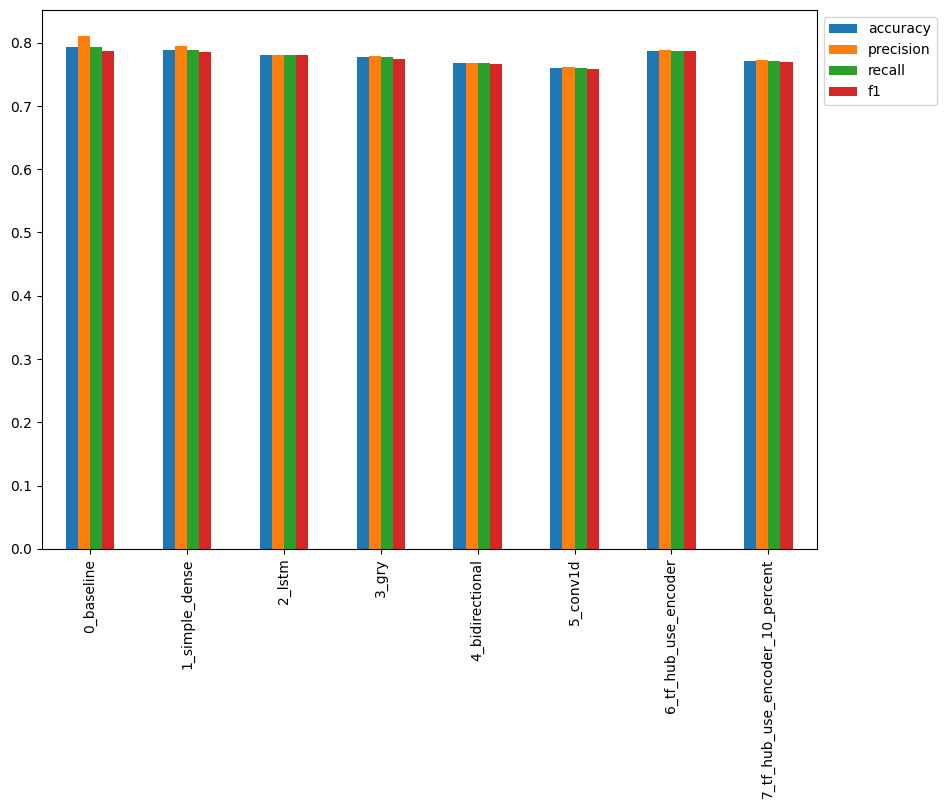

In [ ]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

<Axes: >

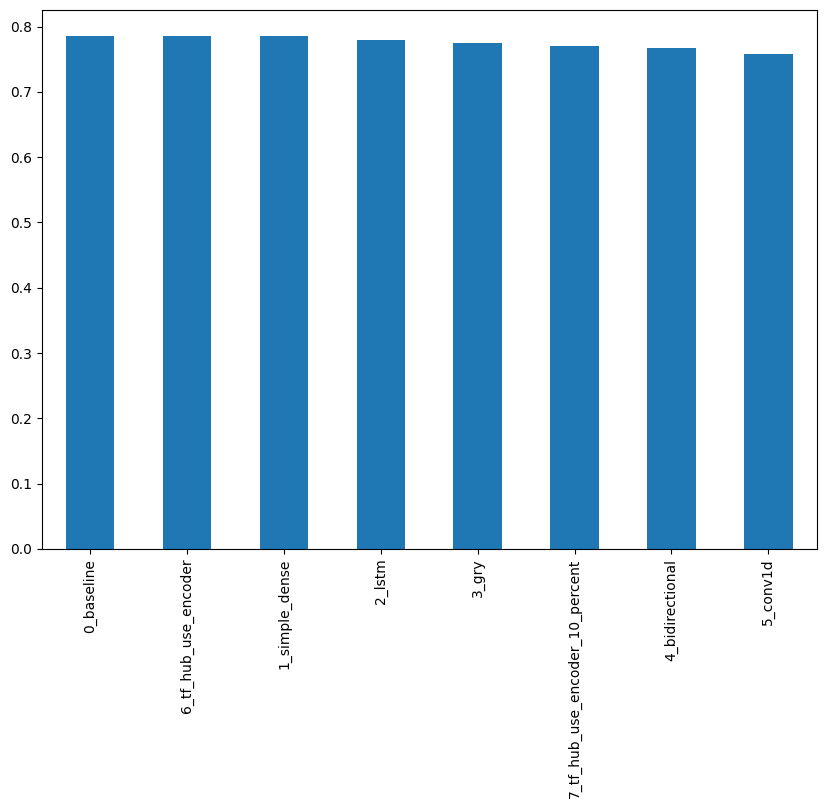

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10,7))

## Uploading our model training logs to Tensorboard.dev
We can futher inspect our model's performance using TensorBoard.dev: https://tensorboard.dev/

📖**Resource:** TensorBoard is great for quickly tracking experiments but for larger scale experiments and a whole bunch more tracking optionsm check out Weights & Biases: https://wandb.ai/site

In [ ]:
# View TensorBoard logs of transfer learning modelling experiments (plus all of our other models)
# Upload TensorBoard dev records
#!tensorboard dev upload --logdir ./model_logs/ \
#  --name "NLP Modelling Experiments ZTM TF Course Video"
#  --description "Comparing multiple different types of model architectures on the Kaggle Tweets text classification dataset"
#  --one_shot # exit the uploader once uploading is finished

Now I've ran the cell above, my modelling experiments are visable on TensorBoard.dev:

In [ ]:
# If you need to delete an experiment from TensorBoard, you can run the following:

## Saving and loading a trained model

There are two main formats to save a model to in TensorFlow:
1. The HDF5 format
2. The `SavedModel` format (this is the default when using TensorFlow)


In [ ]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load model with custom Hub Layer (required HDF5 format)
import tensorflow_hub as hub
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [ ]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 20ms/step - loss: 0.4982 - accuracy: 0.7874


[0.4982381761074066, 0.787401556968689]

In [ ]:
model_6_results

{'accuracy': 78.74015748031496,
 'precision': 0.7882556026650515,
 'recall': 0.7874015748031497,
 'f1': 0.7860325697924123}

Now let's save to the `SavedModel` format....
documentation: https://www.tensorflow.org/tutorials/keras/save_and_load

In [ ]:
# Save TF Hub Sentence Encoder model to SavedModel format (default)
model_6.save("model_6_SavedModel_format")

In [ ]:
# Load in a model from the SavedModel format
loaded_model_6_SavedModel_format = tf.keras.models.load_model("model_6_SavedModel_format")

In [ ]:
# Evaluate model in SavedModel format
loaded_model_6_SavedModel_format.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 12ms/step - loss: 0.4982 - accuracy: 0.7874


[0.4982381761074066, 0.787401556968689]

## Finding the most wrong exmaples

* If our best modle still isn't perfect, what examples is it getting wrong?
* And of these wrong examples which ones is it getting *most* wrong (those will prediction probabilities closest to the opposite class)

Fo example if a sample should have a label of 0 but our model predicts a prediction probability of 0.999 (really close to 1) and vice versa.

In [ ]:
# Download a pretrained model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2023-10-17 19:32:43--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.26.207, 172.217.193.207, 172.217.204.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.26.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M  68.3MB/s    in 13s     

2023-10-17 19:32:57 (68.3 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variables.i

In [ ]:
# Import previouslt trained model from Google Storage
model_6_pretrained = tf.keras.models.load_model("08_model_6_USE_feature_extractor")
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 2s 11ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723119258880615, 0.8162729740142822]

In [ ]:
# Make predictions with the loaded model from GS
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[:10] # these should be in label format

24/24 [==============================] - 1s 32ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Create DataFrame with validation sentences, validation labels and best performing model predictions labels + probabilities
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_pretrained_preds,
                       "pred_prob": tf.squeeze(model_6_pretrained_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [ ]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10] # these are false positive

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.814816
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.810840
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.803122
119,@freefromwolves GodsLove &amp; #thankU brother...,0,1.0,0.766901
344,Air Group is here to the rescue! We have 24/7 ...,0,1.0,0.766625


In [ ]:
most_wrong.tail() # thse are false negatives

,text,target,pred,pred_prob
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


Let's reming ourselves of the target labels...
* `0` = not disaster
* `1` = disaster

In [ ]:
# Check the false positives (model_predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1.0, Prob: 0.9101957082748413
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1.0, Prob: 0.8769820332527161
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1.0, Prob: 0.8523001670837402
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1.0, Prob: 0.8354544043540955
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Pred: 1.0, Prob: 0.8272131681442261
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

----

Target: 0, Pred: 1.0, Prob: 0.814815878868103
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

In [ ]:
# Check the false negatives (model_predicted 0 when should've been 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0.0, Prob: 0.06730345636606216
Text:
@DavidVonderhaar At least you were sincere ??

----

Target: 1, Pred: 0.0, Prob: 0.055075839161872864
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0.0, Prob: 0.054603397846221924
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0.0, Prob: 0.05459701269865036
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Pred: 0.0, Prob: 0.04963730648159981
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0.0, Prob: 0.04391849413514137
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

----

Target: 1, Pred: 0.0, Prob: 0.

## Making predictions on the test dataset

In [ ]:
# Making predictions on the test dataset and visualizing them
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample])) # our model expects a list as input
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("-----\n")


1/1 [==============================] - 0s 55ms/step
Pred: 0, Prob: 0.13665622472763062
Text:
@unitedutilities not happy I received text now about #Parasite danger.I am a #transplantee &amp; #Virus can kill #kidney https://t.co/9AasSFrdP1

-----

1/1 [==============================] - 0s 48ms/step
Pred: 1, Prob: 0.9497310519218445
Text:
Obama Declares Disaster for Typhoon-Devastated Saipan: Obama signs disaster declaration for Northern Marians a... http://t.co/9i6CrCRq2m

-----

1/1 [==============================] - 0s 55ms/step
Pred: 0, Prob: 0.18141821026802063
Text:
I really demolished it

-----

1/1 [==============================] - 0s 137ms/step
Pred: 0, Prob: 0.04730226472020149
Text:
Do you remember when I suddenly electrocute you to death with my fox powers? Ha. Ha. Ha. Ha. Ha. Ha. Because I do.

-----

1/1 [==============================] - 0s 127ms/step
Pred: 1, Prob: 0.8005606532096863
Text:
EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTENERS XrWn

-----

1/1 [==============

## The speed/Score tradeoff

In [ ]:
# Let's make a function to measure the time of prediction
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples)      # make predictions
  end_time = time.perf_counter()    # get finish time
  total_time = end_time-start_time # calculate how long predictions took to make
  time_per_pred = total_time/len(samples)
  return total_time, time_per_pred

In [ ]:
# Calculate TF Hub Sentence Encoder time per pred
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model=model_6_pretrained,
                                                            samples=val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 0s 13ms/step


(0.4196635319995039, 0.0005507395433064356)

In [ ]:
# Calculate our baseline model times per pred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.033533900000293215, 4.400774278253703e-05)

In [ ]:
# Get results for pretrained GS model
model_6_pretrained_results = calculate_results(y_true=val_labels,
                                               y_pred=model_6_pretrained_preds)
model_6_pretrained_results

{'accuracy': 81.62729658792651,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651,
 'f1': 0.8148082644367335}

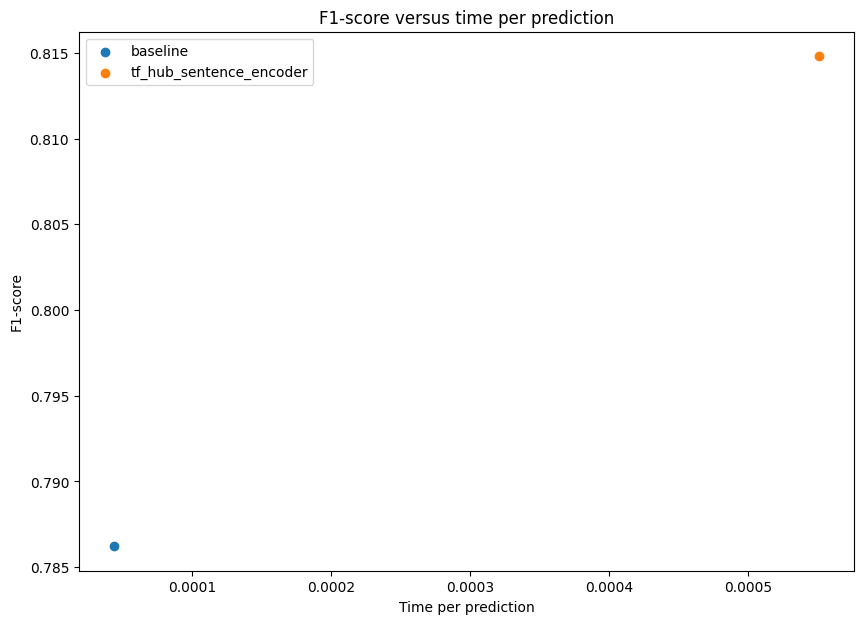

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_pretrained_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-score");